In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
from tqdm import tqdm

# Una partícula en un doble pozo unidimensional asimétrico

Supongamos que tenemos una partícula de masa $m$ en un doble pozo asimétrico de potencial.

In [2]:
m = 14.007 * unit.amu # masa del átomo N

En principio, podemos imaginar que la partícula habita un espacio tridimensional. ¿Cómo sería un doble pozo en tres dimensiones? Lo podemos representar como un potencial harmónico en las dimensiones $Y$ y $Z$ para confinar la partícula a un espacio definido al rededor del mínimo que situaremos en $y=0$ y $z=0$.

\begin{equation*}
V(y,z) = \frac{1}{2}  (y^{2}+z^{2})
\end{equation*}

Para entender un poco de la física de una partícula en un potencial armónico podemos echar un vistazo a [la unidad del repositorio UIBCDF-Academia dedicada a este caso](https://github.com/uibcdf/Academia/blob/master/Ejemplos_de_simulaciones_de_MD/Pozo_Harmónico.ipynb) o [el ejemplo que encontramos en la guía de uso de la librería UIBCDF_test_systems](http://www.uibcdf.org/UIBCDF_test_systems/_build/systems/harmonic_well_potential.html). Hagamos aquí un breve resumen haciendo énfasis en aquello que nos concierne para este notebook. Veamos el potencial unidimensional a lo largo del eje $Y$.

## El potencial armónico para Y y Z

El potencial armónico en cualquiera de las dos dimensiones, $Y$ o $Z$, toma la siguiente forma:

\begin{equation*}
V(y) = \frac{1}{2} k y^{2}
\end{equation*}

In [3]:
def harmonic_well(x,k):
    return 0.5*k*x**2

Donde la constante $k$ del pozo la podemos definir como:

In [4]:
k=20.0 * unit.kilocalories_per_mole/ unit.nanometers**2

Para representar gráficamente el potencial tomemos un conjunto de puntos a lo largo del eje $Y$ y veamos su correspondiente valor de potencial $V(y)$:

In [5]:
y_serie = np.arange(-5., 5., 0.05) * unit.nanometers
Vy_serie = harmonic_well(y_serie, k)

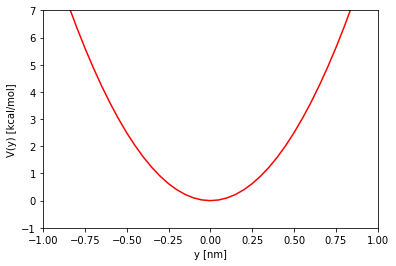

In [6]:
plt.plot(y_serie, Vy_serie, 'r-')
plt.ylim(-1,7)
plt.xlim(-1,1)
plt.xlabel("y [{}]".format(y_serie.unit.get_symbol()))
plt.ylabel("V(y) [{}]".format(Vy_serie.unit.get_symbol()))
plt.rcParams['figure.figsize'] = 6,4
plt.show()

Necesitamos conocer cual es el periodo de oscilación de una partícula libre en el pozo definido por nuestro valor de $k$. ¿Por qué? porque nuestro paso de integración tiene que ser inferior a dicho periodo. No únicamente por si queremos simular el comportamiento dinámico oscilatorio clásico a temperatura $T=0$ de nuestra partícula, sino porque si nuestro paso de integración es mayor o comparable al periodo comenzaremos a tener graves problemas de integración numérica (ver [el notebook de UIBCDF-Academia dedicado al paso de integración]).

Calcular el periodo de las oscilaciones entorno al mínimo de una partícula en un régimen determinista en este caso es trivial, conocemos la relación entre la frecuencia angular de las oscilaciones, y la constante elástica $k$ de nuestro pozo:

\begin{equation*}
\omega = \sqrt{\frac{k}{m}},
\end{equation*}

donde $m$ es la masa de la partícula. O dado que el periodo $T$ esta relacionado con la inversa de la frecuencia angular según:

\begin{equation*}
T = \frac{2\pi}{\omega}
\end{equation*}

Tenemos que:

\begin{equation*}
T = 2\pi \sqrt{\frac{m}{k}}
\end{equation*}

Pero, qué haríamos si no conocieramos la expresión analítica del periodo. En el caso de que nuestro potencial no sea un pozo armónico, sabemos que al menos las pequeñas oscilaciones de una partícula entorno a un mínimo si se aproximan a las oscilaciones de un pozo armónico. Podemos acercarnos al valor del periodo de dichas oscilaciones atendiendo a la segunda derivada del potencial. Cualquier función puede ser aproximada en sus mínimos a pozos armónicos, así entonces el valor de la segunda derivada de un potencial en un mínimo es igual a la frecuencia angular $\omega$ de las pequeñas oscilaciones (ver el notebook XXX).

In [7]:
x = sy.symbols('x')
f=0.5*k*x**2
g=sy.diff(f,x)
gg=sy.diff(f,x,x)
roots_diff=sy.roots(g,x)

print('Calculamos las raices:')
print('')
print('Función:',f)
print('Primera derivada:',g)
print('Segunda derivada:',gg)

roots_yz=[]
for root in roots_diff.keys():
    effective_k=gg.subs(x,root)
    if effective_k>0:
        roots_yz.append(root)
        T = 2*np.pi*np.sqrt(m/(effective_k * unit.kilocalories_per_mole/unit.nanometers**2))
        print('Minimo en coordenada',root*unit.nanometers,'con k effectiva',effective_k* unit.kilocalories_per_mole/unit.angstrom**2,
        ' y un periodo T de oscilación',T)

Calculamos las raices:

Función: 10.0*x**2 kcal/(nm**2 mol)
Primera derivada: 20.0*x
Segunda derivada: 20.0000000000000
Minimo en coordenada 0 nm con k effectiva 20.0000000000000 kcal/(A**2 mol)  y un periodo T de oscilación 2.5706419882292364 ps


Ya tenemos una idea de qué sucederá en los ejes $Y$ y $Z$. Dos hechos son relevantes. La partícula estará confinada por una trampa bidimensional armónica. Y el paso de integración no debería ser según el potencial en $Y$ y $Z$ mayor que $\sim T/10$:

In [8]:
print('El paso del integrador debe ser aproximadamente',T/10, 'o menor.')

El paso del integrador debe ser aproximadamente 0.25706419882292364 ps o menor.


## El doble pozo asimétrico para X

Podemos encontrar una descripción detallada del doble pozo asimétrico unidimensional en la unidad de [UIBCDF-Academia dedicada a este sistema]() o en [la guía de uso de dicho potencial en UIBCDF_Test_Systems](http://www.uibcdf.org/UIBCDF_test_systems/_build/systems/double_well_potential.html). Hagamos aquí una revisión breve y empecemos por ver la forma del potencial doble pozo unidimensional:

\begin{equation*}
V(x) = Ax^{4} + Bx^{2} + Cx
\end{equation*}

Las constantes $A$, $B$ y $C$ que definen el polinomio no tienen así un sentido inmediato. Únicamente $C$ podemos interpretarlo como el responsable de escalar el término que hará que el doble pozo sea más o menos asimétrico. De hecho, si $C=0$ la expresión describe un doble pozo simétrico.

Reescribamos este doble pozo para que nos sea fácil jugar a incrementar la barrera, separar los mínimos o subir o bajar uno de los pozos con respecto al otro:

\begin{equation*}
V(x)=E_{0} \left[ \left(\frac{x}{a}\right)^4 -2\left(\frac{x}{a}\right)^2 \right]-\frac{b}{a}x
\end{equation*}

De esta manera la distancia de los mínimos respecto a $x=0$ viene dada por $a$ y la altura de la barrera para el pozo izquierdo está aproximada por $E_{0}-b$ mientras que para el pozo derecho está aproximada por $E_{0}+b$. Veamos un ejemplo con el que podemos jugar a modificar el valor de dichas constantes:

In [9]:
def double_well(x,Eo,a,b):
    return Eo*((x/a)**4-2*(x/a)**2)-(b/a)*x

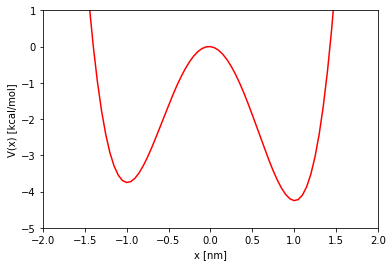

In [10]:
Eo=4.0 * unit.kilocalories_per_mole
a=1.0 * unit.nanometers
b=0.25 * unit.kilocalories_per_mole

x_serie = np.arange(-5., 5., 0.05) * unit.nanometers
Vx_serie = double_well(x_serie, Eo, a, b)

plt.plot(x_serie, Vx_serie, 'r-')
plt.ylim(-5,1)
plt.xlim(-2,2)
plt.xlabel("x [{}]".format(x_serie.unit.get_symbol()))
plt.ylabel("V(x) [{}]".format(Vx_serie.unit.get_symbol()))
plt.rcParams['figure.figsize'] = 6,4
plt.show()

Debemos ahora estudiar de nuevo el periodo de las pequeñas oscilaciones entorno a los mínimo. Este número nos dará una referencia de la escala de tiempo más corta en la situación más desfavorable, el sistema a muy baja temperatura o a temperatura cero desplazandose en el entorno más proximo a uno de los mínimos:

In [11]:
x = sy.symbols('x')
f = Eo*((x*unit.nanometers/a)**4-2*(x*unit.nanometers/a)**2) - (b/a)*x*unit.nanometers


g=sy.diff(f,x)
gg=sy.diff(f,x,x)
roots_diff=sy.roots(g,x)

print('Calculamos las raices:')
print('')
print('Función:',f)
print('Primera derivada:',g)
print('Segunda derivada:',gg)

Ts=[]
roots_x=[]
for root in roots_diff.keys():
    effective_k=gg.subs(x,root)
    if effective_k>0:
        roots_x.append(root)
        T = 2*np.pi*np.sqrt(m/(effective_k * unit.kilocalories_per_mole/unit.nanometer**2))
        Ts.append(T)
        print('Minimo en coordenada',root * unit.nanometer,'con k effectiva',effective_k*unit.kilocalories_per_mole/unit.nanometer**2,
              'y un periodo T de oscilación',T)

Calculamos las raices:

Función: 4.0*x**4 - 8.0*x**2 - 0.25*x kcal/mol
Primera derivada: 16.0*x**3 - 16.0*x - 0.25
Segunda derivada: 48.0*x**2 - 16.0
Minimo en coordenada -0.992093989581487 nm con k effectiva 31.2440232398582 kcal/(nm**2 mol) y un periodo T de oscilación 2.0567102794126755 ps
Minimo en coordenada 1.00772280707545 nm con k effectiva 32.7442522832014 kcal/(nm**2 mol) y un periodo T de oscilación 2.009042184592711 ps


Estos valores de los periodos de las pequeñas oscilaciones entorno a los mínimos nos da otra cota máximas ($\sim T/10$) para el paso de tiempo del integrador:

In [12]:
print('El paso del integrador debe ser aproximadamente',np.min(Ts)/10, 'o menor.')

El paso del integrador debe ser aproximadamente 0.2009042184592711 ps o menor.


## La dinámica de Langevin de nuestro sistema

Dado que vamos a simular con Openmm una partícula de masa $m$ en el doble pozo asimétrico descrito anteriormente, veamos en primer lugar cómo crear el sistema u objeto `System`:

In [13]:
system = mm.System()
mass   = m # la masa fue definida anteriormente
system.addParticle(mass)

0

Añadamos ahora el potencial externo:

In [14]:
# Las constantes k, Eo, a, y b fueron definidas con anterioridad

A = Eo/(a**4)
B = -2.0*Eo/(a**2)
C = -b/a
D = k/2.0

force = mm.CustomExternalForce('A*x^4+B*x^2+C*x + D*(y^2+z^2)')
force.addGlobalParameter('A', A)
force.addGlobalParameter('B', B)
force.addGlobalParameter('C', C)
force.addGlobalParameter('D', D)
force.addParticle(0, [])
system.addForce(force)


0

Ya podemos proceder a simular la dinámica de langevin de nuestro sistema a la temperatura y con la fricción deseadas.

In [15]:
# Parametros del estado termodinámico NVT
temperature = 300*unit.kelvin

In [16]:
# Parametros de la simulación
step_size       = 0.2*unit.picoseconds
num_steps       = 100000
saving_period   = 50
num_steps_saved = int(num_steps/saving_period)

In [17]:
# Integrador de Langevin
friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [18]:
# Plataforma de ejecución
platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

In [19]:
# Reporteros
times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.nanometers)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.nanometers/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies     = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

In [20]:
# Condiciones iniciales y contexto
initial_positions  = [[0.0, 0.0, 0.0]] * unit.nanometers
initial_velocities = [[0.0, 0.0, 0.0]] * unit.nanometers/unit.picoseconds
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [21]:
# Estado
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

In [22]:
# Integración de la dinámica
for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 2000/2000 [00:04<00:00, 436.86it/s]


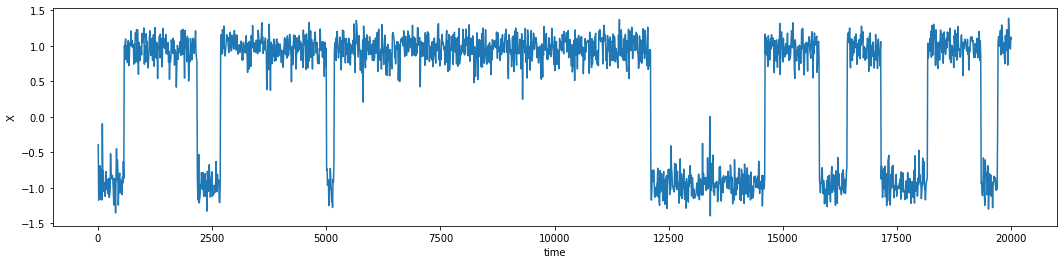

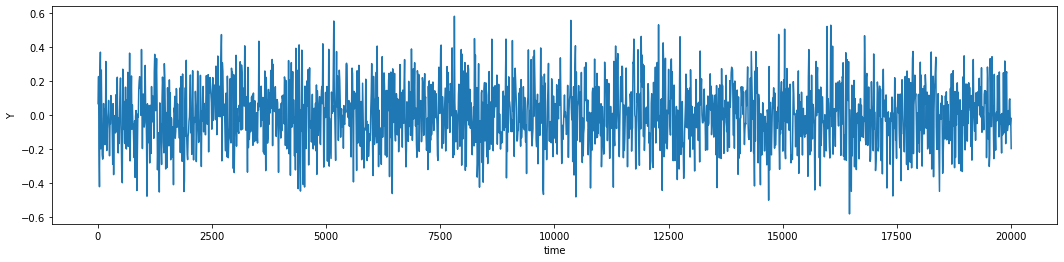

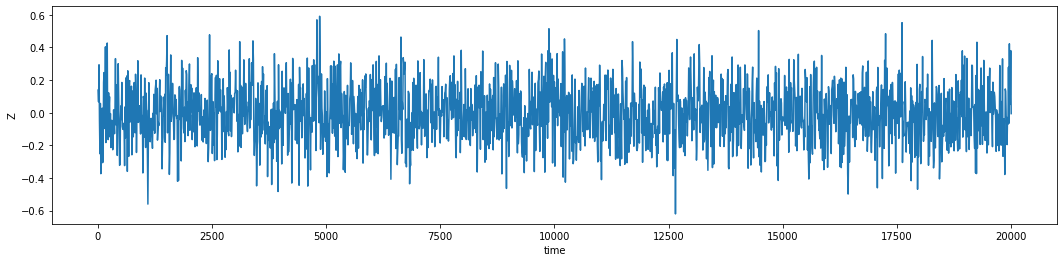

In [23]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

La partícula en un potencial unidimensional de doble pozo es un sistema ideal como banco de pruebas. Para evitar reescribir todo el proceso anterior cada vez que queramos jugar con este sistema, en la UIBCDF lo hemos incluido en una librería llamada [UIBCDF_test_systems](http://www.uibcdf.org/UIBCDF_test_systems). Veremos a continuación que con pocas lineas podemos simular el sistema anterior (ver [la sección dedicada a este potencial en la web de UIBCDF_test_systems](http://www.uibcdf.org/UIBCDF_test_systems/_build/systems/double_well_potential.html)). 

In [64]:
from uibcdf_test_systems import DoubleWell
from uibcdf_test_systems.simulation import langevin_NVT

# Parametros del sistema y el potencial
m = 14.007 * unit.amu
Eo = 4.0 * unit.kilocalories_per_mole
a = 1.0 * unit.nanometers
b = 0.25 * unit.kilocalories_per_mole

# Parametros del estado termodinámico
T = 300*unit.kelvin

# Sistema
double_well_asymmetric = DoubleWell(n_particles = 1, mass = m, Eo = Eo, a = a, b = b)

# Condiciones iniciales
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = 1.1 * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

# Simulación
times, positions, velocities, kinetic_energies, potential_energies = langevin_NVT (double_well_asymmetric.system,
                                                                                   temperature = T,
                                                                                   friction = 1.0/unit.picoseconds,
                                                                                   initial_positions = initial_positions,
                                                                                   initial_velocities = initial_velocities,
                                                                                   integration_timestep = 0.2 * unit.picoseconds,
                                                                                   saving_timestep = 10.0 * unit.picoseconds,
                                                                                   total_time = 200 * unit.nanoseconds,
                                                                                   platform_name='CUDA')

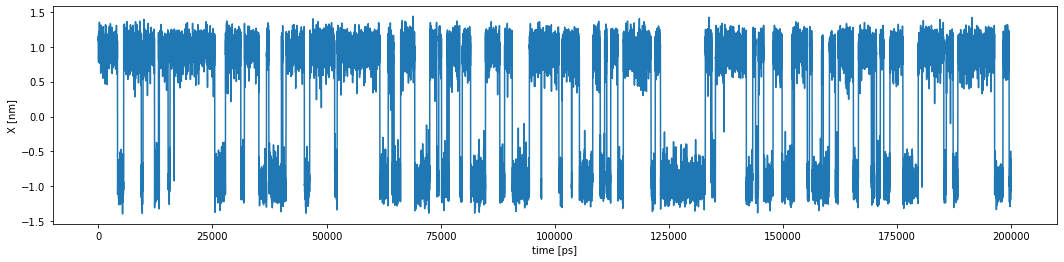

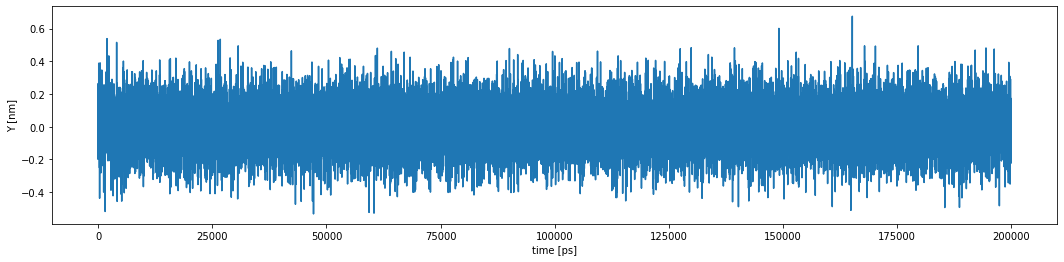

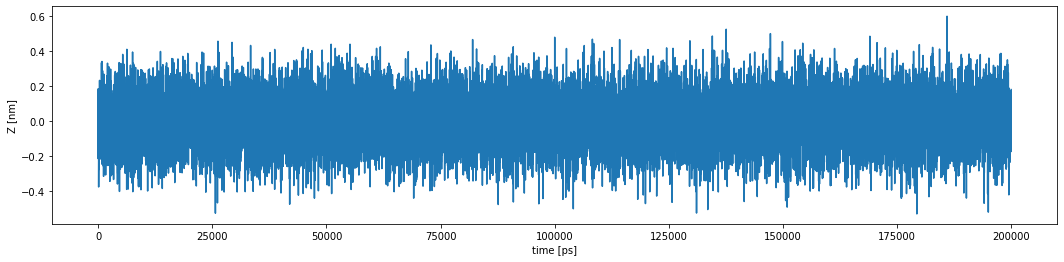

In [65]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,0,ii])
    plt.ylabel(ylabel+' [{}]'.format(positions.unit.get_symbol()))
    plt.xlabel('time [{}]'.format(times.unit.get_symbol()))
    plt.show()

## Distribución de Probabilidad sobre el eje X

### Densidad de probabilidad discreta $P_{x}$ de la simulación

Veamos ahora cual es la distribución de probabilidad $P(x)$ recogida de la trayectoria resultado de una simulación. Comencemos con el histograma que recoge el número de veces que la trayectoria visita un segmento determinado de anchura $delta_x$. Para ello definimos la discretización de la región en el eje $X$ entre un límite mínimo y un límite máximo en $x$ en un número de determinado de segmentos o bins. 

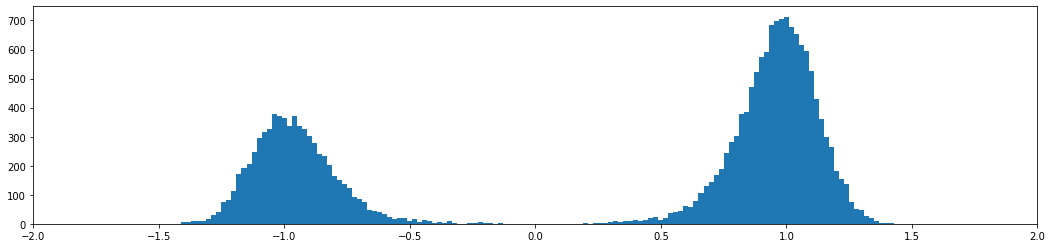

In [66]:
# Numpy cuenta con una función para calcular histogramas

limite_minimo_x = -2.0 * unit.nanometers
limite_maximo_x = 2.0 * unit.nanometers
n_bins = 200
delta_x = (limite_maximo_x - limite_minimo_x)/n_bins 

histograma, bin_limites = np.histogram(positions[:,0,0]._value, bins=n_bins, range=[limite_minimo_x._value, limite_maximo_x._value])

plt.bar(bin_limites[:-1], histograma, width = delta_x._value)
plt.xlim(limite_minimo_x._value, limite_maximo_x._value)
plt.show()

Para calcular la distribución discreta sobre el eje $X$ de la probabilidad $P(x)$ únicamente necesitamos normalizar la distribución de tal manera que:

\begin{equation}
1 = \sum{P_{x_{i}} \Delta x}
\end{equation}

Que no es más que la "discretización" de la condición de cierre de la función de probabilidad $P(x)$:

\begin{equation}
1 = \int_{-\infty}^{\infty} {P(x) dx} \approx
\int_{-2}^{2} {P(x) dx}
\end{equation}

Para ello normalizamos la distribución:

In [67]:
histograma_normalizado = (histograma/histograma.sum())

De esta manera hemos normalizado la distribución, pero todavía no tenemos una distribución de densidad normalizada. Se cumple que:

\begin{equation}
1 = \sum{H_{x_{i}}}
\end{equation}

Donde $H_{x_{i}}$ es el valor normalizado del histograma para la celda entre $x_{i}$ y $x_{i+1}$, pero:

\begin{equation}
1 \neq \sum{H_{x_{i}} \Delta x}
\end{equation}

In [68]:
histograma_normalizado.sum()

1.0

Tenemos que dividir el valor $H_{x_{i}}$ para el valor de la anchura de la celda entre $x_{i}$ y $x_{i+1}$:

In [69]:
densidad_histograma = histograma_normalizado / delta_x

Ahora si podemos ver que:

\begin{equation}
1 = \sum{\hat{H}_{x_{i}} \Delta x}
\end{equation}

In [70]:
(densidad_histograma*delta_x).sum()

1.0

Ahora si podemos interpretar $\hat{H}_{x_{i}}$ como la distribución de probabilidad de ocupación $P_{xi}$ de la celda $[x_{i}, x_{i+1})$ de nuestro sistema recogido de la trayectoria.

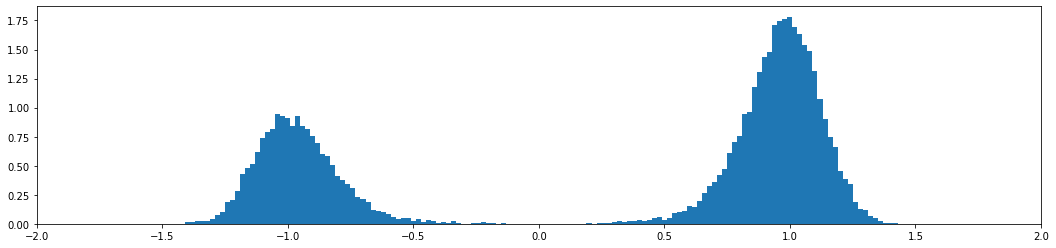

In [71]:
plt.bar(bin_limites[:-1], densidad_histograma._value, width = delta_x._value)
plt.xlim(limite_minimo_x._value, limite_maximo_x._value)
plt.show()

Podríamos haber obtenido estos mismos valores de la densidad de probabilidad discreta $\hat{H}_{x}$ acudiendo a las variables de entrada de la función `numpy.histogram`. Podemos obtener así la densidad del histograma normalizado:

In [72]:
densidad_histograma_numpy, bin_limites = np.histogram(positions[:,0,0]._value, bins=n_bins, 
                                                      range=[limite_minimo_x._value, limite_maximo_x._value], density=True)
densidad_histograma_numpy = densidad_histograma_numpy/unit.nanometers # Para darle dimensionalidad

In [73]:
(densidad_histograma_numpy*delta_x).sum()

1.0000000134048523

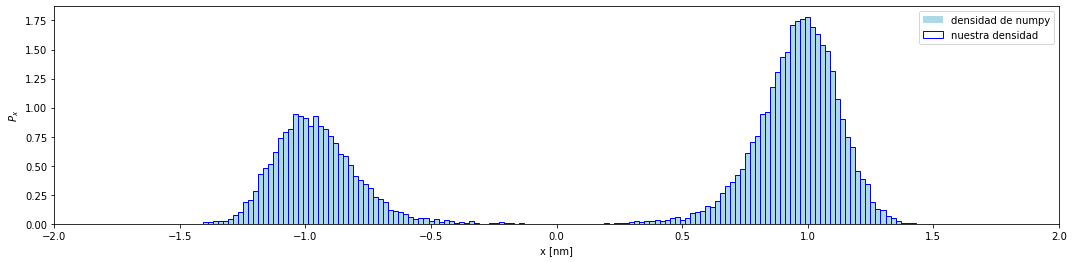

In [74]:
plt.bar(bin_limites[:-1], densidad_histograma_numpy._value, width = delta_x._value, color='lightblue', label='densidad de numpy')
plt.bar(bin_limites[:-1], densidad_histograma._value, width = delta_x._value, fill=False, edgecolor='blue', label='nuestra densidad')
plt.xlim(limite_minimo_x._value, limite_maximo_x._value)
plt.xlabel("x [{}]".format(positions.unit.get_symbol()))
plt.ylabel("$P_{x}$")
plt.legend(loc='upper right')
plt.show()

Ya podemos llamar tranquílamente a esta serie de valores correspondientes a cada celda del eje $X$: densidad de probabilidad discreta recogida de la trayectoria. Podríamos por ejemplo ahora calcular valores como $\langle x \rangle$:

\begin{equation}
\langle x \rangle = 
\int_{-\infty}^{\infty} {xP(x)dx} \approx
\int_{-2}^{2} {xP(x)dx} \approx
\sum_{i}{xP_{x_{i}} \Delta x}
\end{equation}

In [75]:
x_media = 0.0*unit.nanometers

for ii in range(n_bins):
    x_media += (bin_limites[ii]*unit.nanometers)*densidad_histograma[ii]*delta_x
    
print("Posición promedio de la distribución de probabilidad de la trayectoria:", x_media)

Posición promedio de la distribución de probabilidad de la trayectoria: 0.2811749987276269 nm


como $\langle \left(\langle x \rangle- x \right)^{2} \rangle$:

\begin{equation}
\langle \left(\langle x \rangle- x \right)^{2} \rangle =
\int_{-\infty}^{\infty} {\left(\langle x \rangle- x \right)^{2} P(x)dx} \approx
\int_{-2}^{2} {\left(\langle x \rangle- x \right)^{2} P(x)dx} \approx
\sum_{i}{\left(\langle x \rangle- x_{i} \right)^{2} P_{x_{i}} \Delta x}
\end{equation}

In [76]:
sigma2_x = 0.0 * unit.nanometers**2

for ii in range(n_bins):
    sigma2_x += (x_media-bin_limites[ii]*unit.nanometers)**2 *densidad_histograma[ii]*delta_x
    
print("La desviación cuadrática promedio de la distribución de probabilidad de la trayectoria:", sigma2_x)

La desviación cuadrática promedio de la distribución de probabilidad de la trayectoria: 0.8671446297758906 nm**2


o como por ejemplo cuál es la probabilidad de encontrar a la partícula en $x=[-2,0)$:

\begin{equation}
P(-2\le x < 0)= \int_{-2}^{0} P\left( x \right) dx \approx
\sum_{-2\le x_{i}<0} P_{x_{i}} \Delta x
\end{equation}

In [77]:
P_izquierda = 0.0

for ii in range(n_bins):
    if -2.0 <= bin_limites[ii] < 0.0:
        P_izquierda += densidad_histograma[ii]*delta_x
    
print("La probabilidad de que x=[-2.0, 0.0) es:", P_izquierda)

La probabilidad de que x=[-2.0, 0.0) es: 0.35374999999999984


Pero, ¿era necesario calcular $P_{x}$ de la trayectoria para conocer $\langle x \rangle$, $\langle \left(\langle x \rangle- x \right)^{2} \rangle$, o $P(-2\le x < 0)$? No necesariamente. Es verdad que una vez que conocemos $P(x)$, o nos aproximamos con su versión discreta $P_{x}$, ya podemos calcular toda la termodinamica del sistema, podemos calcular el valor esperado de cualquier observable:

\begin{equation}
\langle A \rangle = \int_{-\infty}^{\infty} A(x) P(x) dx
\end{equation}

Sin necesidad de haber calculado la distribución de densidad de probabilidad, podíamos haber calculado estas magnitudes directamente de la trayectoria compuesta por $N$ frames sin más que:

\begin{equation}
\langle A \rangle \approx \sum_{n=0}^{N} \frac{A(n)}{N},
\end{equation}

Veamos el caso, por ejemplo, de esos tres observables anteriores a continuación. Teniendo encuenta que uno de ellos puede ser reescrito como:

\begin{equation}
\langle \left(\langle x \rangle- x \right)^{2} \rangle = 
\langle \langle x \rangle^{2} + x^{2} -2x\langle x \rangle \rangle =
\langle x \rangle^{2} + \langle x^{2} \rangle - 2\langle x \rangle\langle x \rangle =
\langle x^{2} \rangle - \langle x \rangle
^{2}\end{equation}

In [78]:
x_media_tray = 0.0*unit.nanometers
x2_media_tray = 0.0*unit.nanometers**2
P_izquierda_tray = 0.0
n_frames = len(times)

for x in positions[:,0,0]:
    x_media_tray += x
    x2_media_tray += x**2
    if -2.0<=x._value<0.0:
        P_izquierda_tray += 1.0

x_media_tray = x_media_tray/n_frames
x2_media_tray = x2_media_tray/n_frames
sigma2_x_tray = x2_media_tray - x_media_tray**2
P_izquierda_tray = P_izquierda_tray/n_frames

In [79]:
print('La posición promedio directamente de la trayectoria es:', x_media_tray)
print('y la obtenida de la distribución discreta de densidad de probabilidad es:', x_media)

La posición promedio directamente de la trayectoria es: 0.2911986563831568 nm
y la obtenida de la distribución discreta de densidad de probabilidad es: 0.2811749987276269 nm


In [80]:
print('La desviación cuadrática promedio directamente de la trajectoria es:', sigma2_x_tray)
print('y la obtenida de la distribución discreta de densidad de probabilidad es:', sigma2_x)

La desviación cuadrática promedio directamente de la trajectoria es: 0.8669939879246902 nm**2
y la obtenida de la distribución discreta de densidad de probabilidad es: 0.8671446297758906 nm**2


In [81]:
print('La probabilidad de que x=[-2.0,0.0) directamente de la trajectoria es:', P_izquierda_tray)
print('y la obtenida de la distribución discreta de densidad de probabilidad es:', P_izquierda)

La probabilidad de que x=[-2.0,0.0) directamente de la trajectoria es: 0.35375
y la obtenida de la distribución discreta de densidad de probabilidad es: 0.35374999999999984


Cuando comparamos los dos valores de cada observable, según la forma como han sido obtenidos, vemos que puede haber ligeras diferencias. ¿A qué crees que se debe?

Efectivamente, al discretizar el eje $X$ para calcular la distribución discreta de probabilidad estamos realizando una aproximación. Estamos diciendo que todos los $x\in[x_{i}, x_{i+1})$ tienen los mismos valores $P(x)=P(x_{i})$. Tendríamos que hacer una discretización infinitesimalmente fina para obtener el valor esperado teóricamente exacto:

\begin{equation}
\langle A \rangle = \int_{-\infty}^{\infty} A(x) P(x) dx \approx \sum_{x_{i}\in(-\infty,\infty)} P_{x_{i}} \Delta x
\end{equation}

Otra variable que hemos introducido en estos cálculos que es origen de posible error o aproximación son los límites en el rango de la discretización:

\begin{equation}
1 = \int_{-\infty}^{\infty} P(x) dx \approx \int_{lim_{inf}}^{lim_{sup}}{P(x) dx}
\end{equation}

Este último hecho no explica la discrepancia en la precisión obtenida para $\langle x \rangle$ anteriormente por dos vías distintas desde la trayectoria. Ya que conocemos que no se observan eventos fuera de la región elegida.  

### Densidad de probabilidad discreta $P_{x}$ teórica

Conocemos que la función de densidad de probabilidad teórica para una partícula en el espacio tridimensional es:
    
\begin{equation}
P(x,y,z) = \frac{1}{Z} e^{-\frac{V(x,y,z)}{K_{B}T}},
\end{equation}

donde:

\begin{equation}
Z = \iiint_{-\infty}^{\infty} {e^{-\frac{V(x,y,z)}{K_{B}T}}} dx dy dz
\end{equation}

Podemos por tanto calcular la función de densidad de probabilidad $P(x)$ ya que dada la forma de nuestro potencial $V(x,y,z)$ se cumple que:

\begin{equation}
V(x,y,z) = V(x)+V(y)+V(z)
\end{equation}

Así que:

\begin{equation}
P(x) = \frac{1}{Z} \iint_{-\infty}^{\infty} {e^{-\frac{V(x,y,z)}{K_{B}T}}} dy dz,
\end{equation}

Donde, gracias a que nuestro potencial tiene las tres coordenadas en sumandos diferentes:

\begin{equation}
Z = \int_{-\infty}^{\infty} {e^{-\frac{V(x)}{K_{B}T}}} dx \int_{-\infty}^{\infty} {e^{-\frac{V(y)}{K_{B}T}}} dy \int_{-\infty}^{\infty} {e^{-\frac{V(z)}{K_{B}T}}} dz
\end{equation}

Pudiendo reescribir la función de partición total $Z$ como producto de funciones de partición $Z_{x}$, $Z_{y}$ y $Z_{z}$ de cada coordenada:

\begin{equation}
Z_{x} = \int_{-\infty}^{\infty} {e^{-\frac{V(x)}{K_{B}T}}} dx
\end{equation}

\begin{equation}
Z_{y} = \int_{-\infty}^{\infty} {e^{-\frac{V(y)}{K_{B}T}}} dy
\end{equation}

\begin{equation}
Z_{z} = \int_{-\infty}^{\infty} {e^{-\frac{V(z)}{K_{B}T}}} dz
\end{equation}

\begin{equation}
Z=Z_{x}Z_{y}Z_{z}
\end{equation}

De esta manera:

\begin{equation}
P(x) = \frac{1}{Z_{x}} e^{-\frac{V(x)}{K_{B}T}} \cdot \frac{1}{Z_{y}} \int_{-\infty}^{\infty} {e^{-\frac{V(y)}{K_{B}T}}} dy \cdot \frac{1}{Z_{z}} \int_{-\infty}^{\infty} {e^{-\frac{V(z)}{K_{B}T}}} dz
\end{equation}

\begin{equation}
P(x) = \frac{1}{Z_{x}} e^{-\frac{V(x)}{K_{B}T}}
\end{equation}

Queda así demostrado que cuando el potencial permite que la exponencial factorice el termino de $x$, la función $P(x)$ depende únicamente de los términos en $x$. Así que la probabilidad de lo que sucede en el eje $X$ es completamente independiente de lo sucedido en $Y$ y $Z$.

Podemos ahora calcular la función $P(x)$ para nuestro potencial. Lo primero que necesitamos es calcular la constante $Z_{x}$, pero desafortunadamente la integral no es sencillo resolverla analíticamente, así que nos aproximaremos a su valor numéricamente:

In [129]:
Z_x = 0.0
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA

limite_inferior_integral = -4.0
limite_superior_integral = 4.0
n_bins_integral = 1000
bins_limite_inferior_integral = np.linspace(limite_inferior_integral, limite_superior_integral, n_bins_integral, endpoint=False)
delta_x_integral = (bins_limite_inferior_integral[1:]-bins_limite_inferior_integral[:-1]).mean()

for x in bins_limite_inferior_integral:
    Z_x += np.exp(-double_well(x*unit.nanometers,Eo,a,b)/(kB*T)) * delta_x_integral

Así que ya podemos definir la función densidad de probabilidad $P(x)$ para nuestro potencial e incluso representarla gráficamente:

In [134]:
def densidad_probabilidad (x):
    return np.exp(-double_well(x,Eo,a,b)/(kB*T))/Z_x

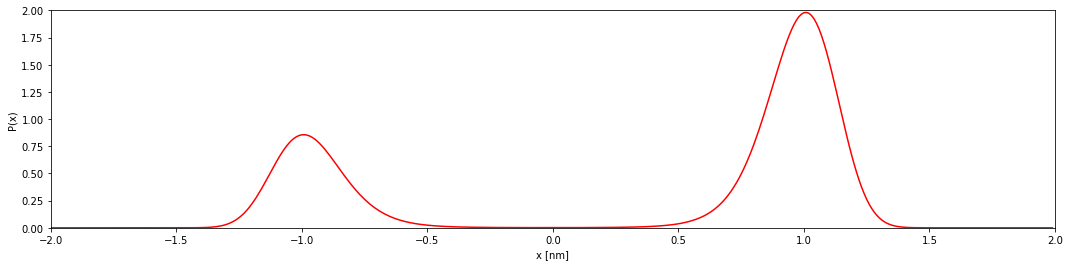

In [139]:
x_serie = np.arange(-2., 2., 0.01) * unit.nanometers
Px_serie = densidad_probabilidad(x_serie)

plt.rcParams['figure.figsize'] = 18,4
plt.plot(x_serie, Px_serie, 'r-')
plt.ylim(0,2)
plt.xlim(-2,2)
plt.xlabel("x [{}]".format(x_serie.unit.get_symbol()))
plt.ylabel("P(x)")
plt.show()

In [ ]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

In [ ]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [ ]:
# ¿Qué pasa si cambiamos el valor de T?

initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = 1.1 * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

times, positions, velocities, kinetic_energies, potential_energies = langevin_NVT (double_well_asymmetric.system,
                                                                                   temperature = 200*unit.kelvin,
                                                                                   friction = 1.0/unit.picoseconds,
                                                                                   initial_positions = initial_positions,
                                                                                   initial_velocities = initial_velocities,
                                                                                   integration_timestep = 0.2 * unit.picoseconds,
                                                                                   saving_timestep = 10.0 * unit.picoseconds,
                                                                                   total_time = 20 * unit.nanoseconds,
                                                                                   platform_name='CPU')

In [ ]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

In [ ]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

In [ ]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

In [ ]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [ ]:
 # ¿Qué pasa si cambiamos el valor del timestep?

initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = 1.1 * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

times, positions, velocities, kinetic_energies, potential_energies = langevin_NVT (double_well_asymmetric.system,
                                                                                   temperature = 200*unit.kelvin,
                                                                                   friction = 1.0/unit.picoseconds,
                                                                                   initial_positions = initial_positions,
                                                                                   initial_velocities = initial_velocities,
                                                                                   integration_timestep = 1.0 * unit.picoseconds,
                                                                                   saving_timestep = 10.0 * unit.picoseconds,
                                                                                   total_time = 20 * unit.nanoseconds,
                                                                                   platform_name='CPU')

In [ ]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

In [ ]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

In [ ]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

In [ ]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [ ]:
 # ¿Qué pasa si cambiamos el valor del damping?

# Diego: Creo que habría que subir el damping... un poco 

initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = 1.1 * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

times, positions, velocities, kinetic_energies, potential_energies = langevin_NVT (double_well_asymmetric.system,
                                                                                   temperature = 200*unit.kelvin,
                                                                                   friction = 1.0/unit.picoseconds,
                                                                                   initial_positions = initial_positions,
                                                                                   initial_velocities = initial_velocities,
                                                                                   integration_timestep = 0.2 * unit.picoseconds,
                                                                                   saving_timestep = 10.0 * unit.picoseconds,
                                                                                   total_time = 20 * unit.nanoseconds,
                                                                                   platform_name='CPU')

In [ ]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(times,positions[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

In [ ]:
hist, bin_edges = np.histogram(positions[:,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

In [ ]:
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,-np.log(hist))
plt.show()

In [ ]:
num_frames = positions.shape[0]
averages   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
std_devs   = unit.Quantity(np.zeros(num_frames, np.float32), unit.angstroms)
    
for ii in np.arange(num_frames):
    averages[ii] = np.mean(positions[:(ii+1),0])
    std_devs[ii]  = np.std(positions[:(ii+1),0])

plt.plot(times,averages)
plt.show()

plt.plot(times,std_devs)
plt.show()

In [ ]:
""""
Notar la naturaleza estocástica
¿Es más conveniente usar un valor de damping ligeramente más alto?
¿Qué pasa si la barrera del pozo es más alta?

""""

- ¿Depende la termodinámica de la fricción? ¿Depende el histograma o la Kd de la fricción?
- ¿Qué sucede si elegimos un paso de integración más alto que el recomendado?
- ¿Qué regula entonces la fricción o damping?¿Lo podemos elegir?
- ¿Qué pasa si la barrera es más alta pero la energía potencial relativa entre los mínimos es igual?

In [ ]:
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA